In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import io
import  nltk.translate.bleu_score as bleu
import pynlpir

In [2]:
# path_to_zip = tf.keras.utils.get_file(
#     'cornell_movie_dialogs.zip',
#     origin=
#     'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
#     extract=True)

# path_to_dataset = os.path.join(
#     os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

# path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
# path_to_movie_conversations = os.path.join(path_to_dataset,
#                                            'movie_conversations.txt')

In [2]:
path_to_zip = 'C:\\Users\\user\\Project From Alex NLP\\chi-eng.zip'
path_to_file = os.path.dirname(path_to_zip)+"\\chi-eng\\cmn.txt"
print(path_to_file)

C:\Users\user\Project From Alex NLP\chi-eng\cmn.txt


In [3]:
# Maximum number of samples to preprocess
# MAX_SAMPLES = 5000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#   sentence = '<start> ' + sentence + ' <end>'
  return sentence


# def load_conversations(num1,num2):
#   # dictionary of line id to text
#   id2line = {}
#   with open(path_to_movie_lines, errors='ignore') as file:
#     lines = file.readlines()
#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     id2line[parts[0]] = parts[4]

#   inputs, outputs = [], []
#   with open(path_to_movie_conversations, 'r') as file:
#     lines = file.readlines()
#   for line in lines[num1:num2]:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     # get conversation in a list of line ID
#     conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
#     for i in range(len(conversation) - 1):
#       inputs.append(preprocess_sentence(id2line[conversation[i]]))
#       outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
# #       if len(inputs) >= MAX_SAMPLES:
# #         return inputs, outputs
#   return inputs, outputs


# questions, answers = load_conversations(0,20000)

In [5]:
# len(questions),len(answers)

In [6]:
# questions_val, answers_val = load_conversations(80001,80500)

In [7]:
# len(questions_val),len(answers_val)

In [8]:
# print('Sample question: {}'.format(questions[20]))
# print('Sample answer: {}'.format(answers[20]))

In [4]:
def create_dataset(path, num1,num2):
  english = []
  chinese = []
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

#   word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  for l in lines[num1:num2]:
      eng = preprocess_sentence(l.split('\t')[0])
      chi = l.split('\t')[1]
      english.append(eng)
      chinese.append(chi)
        
  return english, chinese

In [5]:
en_tr, chi_tr = create_dataset(path_to_file, 0,20000)
print(en_tr[-1])
print(chi_tr[-1])

one man s meat is another man s poison .
甲之蜜糖，乙之砒霜。


In [6]:
len(en_tr),len(chi_tr)

(20000, 20000)

In [7]:
en_val, chi_val = create_dataset(path_to_file,23000,23500)
len(en_val),len(chi_val)

(500, 500)

In [8]:
# Build tokenizer using tfds for both questions and answers
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    en_tr, target_vocab_size=2**13)

tokenizer_chi = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    chi_tr, target_vocab_size=2**13)

# Build tokenizer using tfds for both questions and answers
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13)



In [14]:
# # Define start and end token to indicate the start and end of a sentence
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# # Vocabulary size plus start and end token
# VOCAB_SIZE = tokenizer.vocab_size + 2

In [9]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7301, 5149, 7332, 6165, 8, 3017, 7263]
The original string: Transformer is awesome.


In [10]:
sample_string = en_tr[5000]

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [14, 567, 3, 990, 320, 1]
The original string: she hit the ball hard .


In [11]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

14 ----> she 
567 ----> hit 
3 ----> the 
990 ----> ball 
320 ----> hard
1 ---->  .


In [12]:
sample_string = '很高興認識你'
tokenized_string = tokenizer_chi.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_chi.decode([ts])))

4573 ----> 很高興
575 ----> 認識
9 ----> 你


In [13]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [14]:
def encode(lang1, lang2):
  lang1 = [tokenizer_chi.vocab_size] + tokenizer_chi.encode(
      lang1.numpy()) + [tokenizer_chi.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [15]:
def tf_encode(chi, en):
  result_chi, result_en = tf.py_function(encode, [chi, en], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_chi.set_shape([None])

  return result_chi, result_en

In [16]:
MAX_LENGTH = 40

In [17]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [18]:
train_preprocessed = (
    tf.data.Dataset.from_tensor_slices((chi_tr, en_tr))
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

# val_preprocessed = (
#     tf.data.Dataset.from_tensor_slices((questions_val, answers_val))
#     .map(tf_encode)
#     .filter(filter_max_length))     

In [19]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

# val_dataset = (val_preprocessed
#                .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [26]:
# print('Tokenized sample question: {}'.format(tokenizer_ques.encode(questions[20])))

In [27]:
# # Maximum sentence length
# MAX_LENGTH = 40


# # Tokenize, filter and pad sentences
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []
  
#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # tokenize sentence
#     sentence1 = [tokenizer_ques.vocab_size] + tokenizer_ques.encode(sentence1) + [tokenizer_ques.vocab_size + 1]
#     sentence2 = [tokenizer_ans.vocab_size] + tokenizer_ans.encode(sentence2) + [tokenizer_ans.vocab_size + 1]
#     # check tokenized sentence max length
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)
  
#   # pad tokenized sentences
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
#   return tokenized_inputs, tokenized_outputs


# questions, answers = tokenize_and_filter(questions, answers)

In [28]:
# questions[20]

In [29]:
# answers[20]

In [30]:
# print('Vocab size: {}'.format(VOCAB_SIZE))
# print('Number of samples: {}'.format(len(questions)))

In [31]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# # decoder inputs use the previous target as input
# # remove START_TOKEN from targets
# # dataset = tf.data.Dataset.from_tensor_slices((
# #     {
# #         'inputs': questions
# #         #'dec_inputs': answers[:, :-1]
# #     },
# #     {
# #         'outputs': answers
# #     },
# # ))
# dataset = tf.data.Dataset.from_tensor_slices((questions, answers))
# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
print(train_dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


In [21]:
chi_batch, en_batch = next(iter(train_dataset))
chi_batch

<tf.Tensor: shape=(64, 19), dtype=int64, numpy=
array([[7318,   25, 4240, ...,    0,    0,    0],
       [7318, 3473, 1695, ...,    0,    0,    0],
       [7318, 2101,  369, ...,    0,    0,    0],
       ...,
       [7318,  656, 3872, ...,    0,    0,    0],
       [7318, 3846,  644, ...,    0,    0,    0],
       [7318, 1107,   31, ...,    0,    0,    0]], dtype=int64)>

In [22]:
en_batch

<tf.Tensor: shape=(64, 12), dtype=int64, numpy=
array([[7473,    9,   12,  114,  948,  789,   17, 1813,    1, 7474,    0,
           0],
       [7473,    8,   20, 3275, 1169,    4, 2152,    6, 7474,    0,    0,
           0],
       [7473,    2, 2091,   11,   12,  518,   20,  178,    1, 7474,    0,
           0],
       [7473,   66,   30,  919,   16,    4,   38,    1, 7474,    0,    0,
           0],
       [7473,   14,    8,   79,    4, 6771, 3249,    1, 7474,    0,    0,
           0],
       [7473,   28,    5,  112, 2210,   64, 4492, 2477,    6, 7474,    0,
           0],
       [7473,    2, 6915,    7, 1167,    1, 7474,    0,    0,    0,    0,
           0],
       [7473,   16,  124, 2244,  204,   16, 3438,    1, 7474,    0,    0,
           0],
       [7473,    5,  157,   36,    5,   54, 1446,    1, 7474,    0,    0,
           0],
       [7473,    2,  277,  780,    3,  308,   69, 1184,    1, 7474,    0,
           0],
       [7473,   59,  764,   24, 1750,   32,    2,   82, 1920, 

# Positional Encoding 

In [23]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [24]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


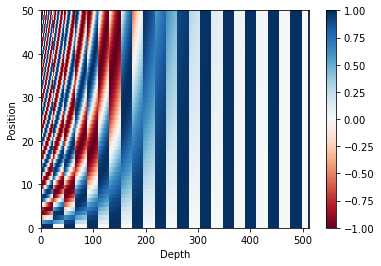

In [25]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [26]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [27]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [28]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [29]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled Dot Product Attention

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [31]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [32]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [33]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [34]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [35]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# Multi-head attention

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [37]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point Wise Feed Forward Network

In [38]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [39]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and Decoder

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [41]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [42]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [43]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

In [44]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [45]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder

In [46]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [47]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Create The Transformer

In [48]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [49]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Set Hyperparameters

In [50]:
num_layers = 6
d_model = 512
dff = 1024
num_heads = 8

input_vocab_size = tokenizer_chi.vocab_size + 2 #questions.vocab_size #+ 2
target_vocab_size = tokenizer_en.vocab_size + 2 #answers.vocab_size #+ 2
dropout_rate = 0.1

# Optimizer

In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [52]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

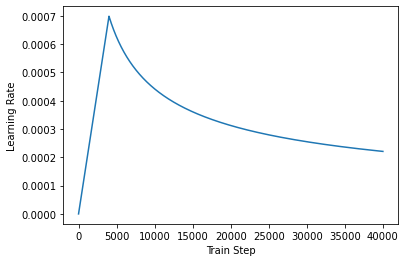

In [53]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [55]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Training and Checkpointing

In [57]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [58]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [59]:
checkpoint_path = "./checkpoints/train_nmt_chi_to_eng_transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [60]:
EPOCHS = 20

In [61]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [62]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.9804 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.5415 Accuracy 0.0503
Epoch 1 Batch 100 Loss 8.0858 Accuracy 0.0694
Epoch 1 Batch 150 Loss 7.7569 Accuracy 0.0758
Epoch 1 Batch 200 Loss 7.4061 Accuracy 0.0912
Epoch 1 Batch 250 Loss 7.0364 Accuracy 0.1119
Epoch 1 Batch 300 Loss 6.7192 Accuracy 0.1269
Epoch 1 Loss 6.6535 Accuracy 0.1298
Time taken for 1 epoch: 51.32372999191284 secs

Epoch 2 Batch 0 Loss 4.8666 Accuracy 0.2005
Epoch 2 Batch 50 Loss 4.8365 Accuracy 0.2078
Epoch 2 Batch 100 Loss 4.7672 Accuracy 0.2128
Epoch 2 Batch 150 Loss 4.7075 Accuracy 0.2174
Epoch 2 Batch 200 Loss 4.6535 Accuracy 0.2205
Epoch 2 Batch 250 Loss 4.5910 Accuracy 0.2241
Epoch 2 Batch 300 Loss 4.5333 Accuracy 0.2268
Epoch 2 Loss 4.5161 Accuracy 0.2276
Time taken for 1 epoch: 31.956395149230957 secs

Epoch 3 Batch 0 Loss 4.0333 Accuracy 0.2370
Epoch 3 Batch 50 Loss 4.0329 Accuracy 0.2567
Epoch 3 Batch 100 Loss 3.9946 Accuracy 0.2593
Epoch 3 Batch 150 Loss 3.9587 Accuracy 0.2607
Epoch 3 Batc

Epoch 20 Batch 250 Loss 1.2214 Accuracy 0.4776
Epoch 20 Batch 300 Loss 1.2378 Accuracy 0.4772
Saving checkpoint for epoch 20 at ./checkpoints/train_nmt_chi_to_eng_transformer\ckpt-4
Epoch 20 Loss 1.2411 Accuracy 0.4768
Time taken for 1 epoch: 34.697620153427124 secs



# Evaluate

In [63]:
def evaluate(inp_sentence):
  start_token = [tokenizer_chi.vocab_size]
  end_token = [tokenizer_chi.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_chi.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [64]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_chi.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_chi.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [65]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted Translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)
    
  return predicted_sentence

In [66]:
# translate("Yesterday I went to a bookstore",plot='decoder_layer4_block2')

In [67]:
# translate("Yesterday I went to a bookstore")

In [68]:
translate('你好嗎？')

Input: 你好嗎？
Predicted Translation: hi ?


'hi ?'

In [69]:
translate('你要去哪裡？')

Input: 你要去哪裡？
Predicted Translation: where are you going ?


'where are you going ?'

In [71]:
translate('很高興認識你')

Input: 很高興認識你
Predicted Translation: you re not happy .


'you re not happy .'

In [72]:
# # feed the model with its previous output
# sentence = 'I am not crazy, my mother had me tested.'
# for _ in range(5):
#   sentence = chatbot(sentence)
#   print('')

In [73]:
# # feed the model with its previous output
# sentence = 'Who are you?'
# for _ in range(5):
#   sentence = chatbot(sentence)
#   print('')

In [74]:
transformer.save_weights('/weights/nmt_eng_to_chi_transformer_ckpt')

In [77]:
# del en_val[36]
# del chi_val[36]
# del en_val[123]
# del chi_val[123]
# del en_val[149]
# del chi_val[149]

In [78]:
len(en_val)

497

In [80]:
bleuplus = 0
i = 0

for chi_, en_ in zip(chi_val,en_val):
    print(i)
    predicted = translate(chi_)
    print('Real Translation: {}'.format(en_))
    bleu_ = bleu.sentence_bleu([en_.split()], predicted.split())
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_
    i += 1

0
Input: 如果你有一万美元，你想做什么呢？
Predicted Translation: you can do it , yen ?
Real Translation: what would you do if you had ten thousand dollars ?
BLEU Score:  8.324264127738903e-232
--------------------------------------------------------------------------------
1
Input: 每次听到这首歌，都会让我回忆起自己年轻的时候。
Predicted Translation: no one told me  , no one .
Real Translation: when i hear that song , i remember my younger days .
BLEU Score:  7.813508425061864e-232
--------------------------------------------------------------------------------
2
Input: 你上一次用Facebook是什麼時候？
Predicted Translation: what do you want to dance ?
Real Translation: when was the last time you spent time on facebook ?
BLEU Score:  7.521821744402224e-232
--------------------------------------------------------------------------------
3
Input: 你记事情的能力并不比我好多少。
Predicted Translation: you can count to hurt that .
Real Translation: you are no better at remembering things than i am .
BLEU Score:  7.521821744402224e-232
---------------------

Input: 在光滑的路上开车会导致车祸。
Predicted Translation: take a bus to the door to the bus to the door .
Real Translation: driving on a slippery road can lead to a car wreck .
BLEU Score:  1.2627076138080564e-231
--------------------------------------------------------------------------------
30
Input: 大象是如今现存的陆生动物里最大的。
Predicted Translation: the boat was covered by snow .
Real Translation: elephants are the largest land animals alive today .
BLEU Score:  1.0009379942300742e-231
--------------------------------------------------------------------------------
31
Input: 屋裡的每個人都被發生的事驚住了。
Predicted Translation: a man was given a gift .
Real Translation: everybody in the room was stunned by what happened .
BLEU Score:  8.676910262183261e-232
--------------------------------------------------------------------------------
32
Input: 除了汤姆以外任何人都知道他没必要这么做。
Predicted Translation: tom knows what he knows everything .
Real Translation: everyone except tom knew he didn t need to do that .
BLEU Score:  7.2161206

Input: 我想去換我昨天買的這件襯衫。
Predicted Translation: i d like to reserve a room by air .
Real Translation: i d like to exchange this shirt i bought yesterday .
BLEU Score:  0.2513293635022765
--------------------------------------------------------------------------------
60
Input: 除非他们事先修好刹车，我才会买车子。
Predicted Translation: tell me and tell an eye for an hour .
Real Translation: i ll only buy the car if they fix the brakes first .
BLEU Score:  7.58961907326157e-232
--------------------------------------------------------------------------------
61
Input: 我很失望我沒能和她一起去。
Predicted Translation: i didn t see myself at her .
Real Translation: i m disappointed that i wasn t able to go with her .
BLEU Score:  4.127681278534973e-155
--------------------------------------------------------------------------------
62
Input: 我现在在去车站见汤姆的路上。
Predicted Translation: i want to go to the party .
Real Translation: i m on my way to meet tom at the station right now .
BLEU Score:  7.236523273960503e-232
-----------

Input: 她唱歌唱得比班上任何一個人好。
Predicted Translation: she gave birth to hear a nice story .
Real Translation: she can sing better than anybody else in her class .
BLEU Score:  1.0016022933125248e-231
--------------------------------------------------------------------------------
91
Input: 她锻炼时扭伤了脚踝。
Predicted Translation: she was aching all of black .
Real Translation: she twisted her ankle while she was doing exercise .
BLEU Score:  5.023587836914362e-155
--------------------------------------------------------------------------------
92
Input: 她已经无法用语言表达她的感觉了。
Predicted Translation: she can speak through english .
Real Translation: she was at a loss for words to express her feeling .
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
93
Input: 她给他写了一封长信，但是他没有看。
Predicted Translation: she pretended to hear a lie .
Real Translation: she wrote him a long letter , but he didn t read it .
BLEU Score:  5.4227507780138046e-232
-----

Input: 湯姆知道我想盡早離開。
Predicted Translation: tom will see you again .
Real Translation: tom knows that i want to leave as soon as possible .
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
122
Input: 汤姆把他的太阳镜留在我的车的仪表板上了。
Predicted Translation: tom lost his keys .
Real Translation: tom left his sunglasses on the dashboard of my car .
BLEU Score:  4.829395330616745e-232
--------------------------------------------------------------------------------
123
Input: 湯姆說瑪麗絕不會接受這工作。
Predicted Translation: tom knew what he will see mary .
Real Translation: tom says that mary definitely won t accept the job .
BLEU Score:  9.798412298238562e-232
--------------------------------------------------------------------------------
124
Input: 汤姆跟我说我不应该晚上一个人出门。
Predicted Translation: tom told me he couldn t help me help me .
Real Translation: tom told me that i shouldn t go out alone at night .
BLEU Score:  3.228231538895496e-78
------------

Input: 寧為貓頭不為獅尾。
Predicted Translation: i d rather be a plain than a horse .
Real Translation: better be the head of a cat than the tail of a lion .
BLEU Score:  1.0269115342717184e-231
--------------------------------------------------------------------------------
152
Input: 你能把你的自行车借我两天吗？
Predicted Translation: will you move a doctor ?
Real Translation: could you lend me your bicycle for a couple of days ?
BLEU Score:  5.635809992474887e-232
--------------------------------------------------------------------------------
153
Input: 你知道有些狐狸住在這座山上嗎?
Predicted Translation: do you have a new shirt ?
Real Translation: did you know that some foxes lived on this mountain ?
BLEU Score:  7.521821744402224e-232
--------------------------------------------------------------------------------
154
Input: 您知道这座庙宇供奉的是哪个神吗？
Predicted Translation: which do you prefer , do by canada ?
Real Translation: do you know which deity this temple is dedicated to ?
BLEU Score:  5.798881106377341e-155
---------

Input: 我認為你該在今天回家前做。
Predicted Translation: i d better you re here today .
Real Translation: i think you should do that before you go home today .
BLEU Score:  4.677275655524805e-155
--------------------------------------------------------------------------------
182
Input: 我觉得吃完那块大牛排你就饱了。
Predicted Translation: i wish you could agree with you .
Real Translation: i thought you d be full after eating that big steak .
BLEU Score:  8.647068503442337e-232
--------------------------------------------------------------------------------
183
Input: 我希望離開這個村子並且再也不要回來。
Predicted Translation: i hope i ll stop this again .
Real Translation: i would like to leave this town and never come back .
BLEU Score:  8.647068503442337e-232
--------------------------------------------------------------------------------
184
Input: 我写了封信，叫他早点回。
Predicted Translation: i hear my father a letter from me .
Real Translation: i wrote a letter asking him to return a bit earlier .
BLEU Score:  5.189066807518457e-155


Input: 她把信从日语译成法语。
Predicted Translation: she went french to learn japanese weekend .
Real Translation: she translated the letter from japanese into french .
BLEU Score:  1.3519605352440902e-231
--------------------------------------------------------------------------------
212
Input: 她挥着她的手，直到火车消失在视线之外。
Predicted Translation: she left married in the same trip .
Real Translation: she waved her hand until the train was out of sight .
BLEU Score:  8.647068503442337e-232
--------------------------------------------------------------------------------
213
Input: 她走過去看看她的名字是否在清單上。
Predicted Translation: she scolded her son to visit her son .
Real Translation: she went over the list to see if her name was there .
BLEU Score:  9.537683887743056e-232
--------------------------------------------------------------------------------
214
Input: 既然母亲病了，我就待在家里没去上学。
Predicted Translation: if you will be late .
Real Translation: since my mother was sick , i stayed home from school .
BLEU Score:  4.28

Input: 你觉得我明天约会穿什么好呢？
Predicted Translation: what would you want to know ?
Real Translation: what do you think i should wear on my date tomorrow ?
BLEU Score:  7.216120604020078e-232
--------------------------------------------------------------------------------
241
Input: 當我聽到這首歌，我想起了你，並想念著你。
Predicted Translation: i m going to see you wherever you go .
Real Translation: when i hear this song , i think of you , and miss you .
BLEU Score:  8.78771736427028e-232
--------------------------------------------------------------------------------
242
Input: 他小时候，星期天会去钓鱼。
Predicted Translation: my doctor comes to an hour .
Real Translation: when he was a child , he would go fishing on sundays .
BLEU Score:  4.753148692240233e-232
--------------------------------------------------------------------------------
243
Input: 看完这封信请把它烧掉。
Predicted Translation: please take care of the cake .
Real Translation: when you have finished reading this letter , burn it .
BLEU Score:  6.325072941044999e-232

Input: 我听说你通过了入学考试。恭喜你了！
Predicted Translation: i ll pay you whatever you luck .
Real Translation: i hear you passed the entrance exam . congratulations !
BLEU Score:  1.1103055738259992e-231
--------------------------------------------------------------------------------
272
Input: 我在回答之前必须考虑周全。
Predicted Translation: i ll see you three days .
Real Translation: i must think over the matter before giving my answer .
BLEU Score:  7.521821744402224e-232
--------------------------------------------------------------------------------
273
Input: 我不该把一整包薯片都吃完的。
Predicted Translation: i shouldn t remember the sentence .
Real Translation: i shouldn t have eaten the whole bag of potato chips .
BLEU Score:  2.7930000273432614e-78
--------------------------------------------------------------------------------
274
Input: 我觉得汤姆不太可能会当选。
Predicted Translation: i think it will be true .
Real Translation: i think that it s unlikely that tom will get elected .
BLEU Score:  4.289355579968415e-155
-----

Input: 她跑得很快是为了赶上其他成员。
Predicted Translation: she married a rich as a coward .
Real Translation: she ran very fast to catch up with the other members .
BLEU Score:  7.813508425061864e-232
--------------------------------------------------------------------------------
302
Input: 她的英語說得比班上任何人都好。
Predicted Translation: her english can speak english story .
Real Translation: she speaks english better than any of her classmates .
BLEU Score:  9.602579706020654e-232
--------------------------------------------------------------------------------
303
Input: 她是個又高又瘦, 留著一頭又長又軟的褐色頭髮的女孩。
Predicted Translation: have a beautiful sense and beautiful .
Real Translation: she was a tall , thin girl with long , soft brown hair .
BLEU Score:  4.900008468089985e-232
--------------------------------------------------------------------------------
304
Input: 她下周日回家，也就是10号。
Predicted Translation: if you get home , we ll get home .
Real Translation: she will return home next sunday , that is , the tenth .
BL

Input: Tom告诉我他们有想要娶你的想法。
Predicted Translation: tom refused me your name .
Real Translation: tom told me that he has no intention of marrying you .
BLEU Score:  5.635809992474887e-232
--------------------------------------------------------------------------------
331
Input: 我们很期待见到您和您的家人。
Predicted Translation: you d better if you want to see .
Real Translation: we are looking forward to seeing you and your family .
BLEU Score:  1.1084551487393798e-231
--------------------------------------------------------------------------------
332
Input: 我们必须调查医生的失踪案。
Predicted Translation: we must get the best sauce .
Real Translation: we have to look into the disappearance of the doctor .
BLEU Score:  8.324264127738903e-232
--------------------------------------------------------------------------------
333
Input: 我們只是需要確認Tom有要來這。
Predicted Translation: we just just just just just just just just just just just just just just just just just just just just just just just just just just just just 

Input: 英语是当今世界上一种非常重要的语言。
Predicted Translation: health is better than beautiful .
Real Translation: english is a very important language in today s world .
BLEU Score:  6.016112399618114e-232
--------------------------------------------------------------------------------
360
Input: 除了汤姆以外任何人都知道他没必要这么做。
Predicted Translation: tom knows what he knows everything .
Real Translation: everybody but tom knew that he didn t need to do that .
BLEU Score:  6.255495473556936e-232
--------------------------------------------------------------------------------
361
Input: 事实是倔强的，但统计是柔顺的。
Predicted Translation: which young or or fire , yen .
Real Translation: facts are stubborn things , but statistics are pliable .
BLEU Score:  1.0032743411283238e-231
--------------------------------------------------------------------------------
362
Input: 他让妹妹帮他涂他房间的墙。
Predicted Translation: he made his wife a new suit .
Real Translation: he had his sister help him paint the wall of his room .
BLEU Score:  7.63

Input: 我刚才说的内容，你想补充么？
Predicted Translation: you owe a doctor , don t you ?
Real Translation: is there anything you want to add to what i just said ?
BLEU Score:  8.020204191025903e-232
--------------------------------------------------------------------------------
390
Input: 快11点了。我们该上床睡觉了。
Predicted Translation: we have to get a little break .
Real Translation: it is close to eleven . it s about time we went to bed .
BLEU Score:  5.9430374753870144e-232
--------------------------------------------------------------------------------
391
Input: 人們似乎只在夏天烤肉。
Predicted Translation: the lot of people .
Real Translation: it seems that most people only barbeque in the summer .
BLEU Score:  4.829395330616745e-232
--------------------------------------------------------------------------------
392
Input: 很难在2、3年内掌握法语。
Predicted Translation: it s fun for peace .
Real Translation: it s quite difficult to master french in or years .
BLEU Score:  3.645525559050358e-155
--------------------------

Input: 汤姆本可以用更好的方式处理问题。
Predicted Translation: tom can read a lot better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better better 
Real Translation: tom could have dealt with the problem in a better way .
BLEU Score:  9.533966891110756e-232
--------------------------------------------------------------------------------
420
Input: 汤姆昨晚三点多才睡着。
Predicted Translation: tom died three months ago .
Real Translation: tom couldn t get to sleep till after three last night .
BLEU Score:  5.635809992474887e-232
--------------------------------------------------------------------------------
421
Input: 汤姆似乎不想告诉我为什么他要那样做。
Predicted Translation: tom didn t know what he did that .
Real Translation: tom didn t seem to want to tell me why he d done that .
BLEU Score:  2.7259440984495877e-78
----------------------------------

Input: 跟我的老師談過後，我決定認真努力。
Predicted Translation: if you get to be young man , yen .
Real Translation: after i talked with my teacher , i decided to work hard .
BLEU Score:  9.988500430528834e-232
--------------------------------------------------------------------------------
449
Input: 讀完他的書後，我覺得我可以構建一棟房子。
Predicted Translation: my brother bought a new teacher .
Real Translation: after reading his books i feel i can construct a house .
BLEU Score:  6.520501036082648e-232
--------------------------------------------------------------------------------
450
Input: 所有的马都是动物，但并非所有的动物都是马。
Predicted Translation: well , all of fire , and the you , and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and 
Real Translation: all horses are animals , but not all animals are horses .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
451
Input: 请问波士顿和悉尼之间有直飞航班吗？
Predicted

Input: 我从不回复陌生人发来的电子邮件。
Predicted Translation: i ve brought my pencil a shorter dollars .
Real Translation: i never answer email messages from people i don t know .
BLEU Score:  8.962731118674859e-232
--------------------------------------------------------------------------------
479
Input: 我很期待在不久的將來您的光臨。
Predicted Translation: i m sorry to bother you next luck .
Real Translation: i really look forward to your visit in the near future .
BLEU Score:  9.918892480173173e-232
--------------------------------------------------------------------------------
480
Input: 我跟英语母语者学了四年英语。
Predicted Translation: i m studying french fluently .
Real Translation: i studied english for four years with a native speaker .
BLEU Score:  6.016112399618114e-232
--------------------------------------------------------------------------------
481
Input: 我很渴，想喝点冷饮。
Predicted Translation: i prefer milk to juice .
Real Translation: i was quite thirsty and wanted to drink something cool .
BLEU Score:  6.65792281

In [104]:
# bleuplus = 0

# for ques_, ans_ in zip(questions_val,answers_val):
#     predicted = chatbot(ques_)
#     print('Real Response: {}'.format(ans_))
#     bleu_ = bleu.sentence_bleu([ans_.split()], predicted.split())
#     print("BLEU Score: ", bleu_)
#     print("----" *20)

#     bleuplus += bleu_

In [85]:
bleuplus/len(en_val)

0.0030524480084224183

Input: 你好嗎？
Predicted Translation: hi ?


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22909 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 21966 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-pac

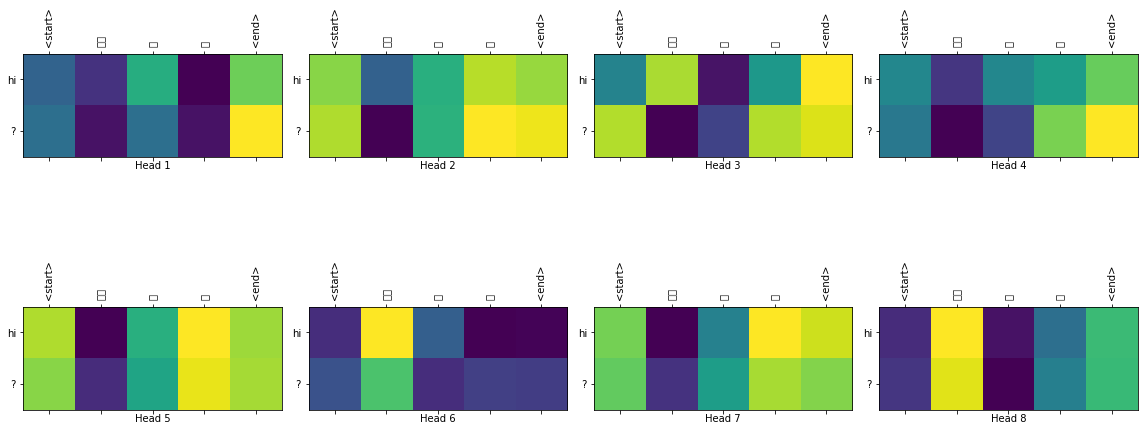

'hi ?'

In [86]:
translate("你好嗎？",plot='decoder_layer4_block2')

In [87]:
transformer.save_weights('/weights/nmt_chi_to_eng_transformer_ckpt')